### Installing NGBoost

In [1]:
#!pip install -q ngboost

In [12]:
import numpy as np
import pandas as pd

from mlforecast import MLForecast
from mlforecast.utils import generate_daily_series

In [3]:
# Generating a synthetic timeseries dataset with 50 timeseries and with length between 50 and 500
data = generate_daily_series(50,min_length=50, max_length=500, seed=42)

### Adding a few features we learned to make this into a regression problem

In [4]:
from mlforecast.lag_transforms import RollingMean, ExpandingMean, Offset
fcst = MLForecast(
    models=[],
    freq='D',
    lags=[1,2,3,4, 7], # Defining the Lags we need to create
    # Defining some transformations we need to do to the lags (offsets)
    lag_transforms={
        1: [ExpandingMean(), RollingMean(window_size=7, min_samples=1), RollingMean(window_size=14)],
    },
)
data = fcst.preprocess(data)
data.head()

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag7,expanding_mean_lag1,rolling_mean_lag1_window_size7_min_samples1,rolling_mean_lag1_window_size14
14,id_00,2000-01-15,0.091118,6.195530,5.086682,4.416597,3.304998,0.115447,3.221919,3.225914,3.221919
15,id_00,2000-01-16,1.377681,0.091118,6.195530,5.086682,4.416597,1.120513,3.013199,3.222439,3.204131
16,id_00,2000-01-17,2.212578,1.377681,0.091118,6.195530,5.086682,2.341632,2.910979,3.259177,3.215019
17,id_00,2000-01-18,3.103971,2.212578,1.377681,0.091118,6.195530,3.304998,2.869897,3.240741,3.229729
18,id_00,2000-01-19,4.283850,3.103971,2.212578,1.377681,0.091118,4.416597,2.882901,3.212023,3.203506


### NGBoost

In [5]:
from ngboost import NGBRegressor
from ngboost.distns import Normal
from sklearn.model_selection import train_test_split

In [6]:
n_val = 15
dates = data['ds'].unique().tolist()
train_dates = dates[:-n_val]
val_dates = dates[-n_val:]

train = data[data['ds'].isin(train_dates)]
val = data[data['ds'].isin(val_dates)]
train_keys = train[["unique_id", 'ds']]
val_keys = val[["unique_id", 'ds']]
train = train.drop(['unique_id', 'ds'], axis=1)
val = val.drop(['unique_id', 'ds'], axis=1)
X_train, Y_train = train.drop(['y'], axis=1), train['y']
X_val, Y_val = val.drop(['y'], axis=1), val['y']

#### Training

In [7]:
# Training the model
ngb = NGBRegressor(Dist=Normal).fit(X_train, Y_train)

[iter 0] loss=2.1140 val_loss=0.0000 scale=2.0000 norm=3.6520
[iter 100] loss=0.9338 val_loss=0.0000 scale=2.0000 norm=1.0973
[iter 200] loss=0.0570 val_loss=0.0000 scale=2.0000 norm=0.9096
[iter 300] loss=-0.4387 val_loss=0.0000 scale=2.0000 norm=0.7104
[iter 400] loss=-0.5339 val_loss=0.0000 scale=2.0000 norm=0.7802


#### Inference

In [8]:
# Point Forecast
y_pred = ngb.predict(X_val)
y_pred

array([2.25359311, 3.24466979, 4.24499496, 5.2257237 , 6.25681586,
       1.26149049, 2.26052604, 3.25243296, 4.23725776, 5.23558159,
       6.24175365, 0.25982509, 1.25550649, 2.25635453, 3.24258026,
       4.24904223, 5.22236826, 6.24525512, 5.22620489, 6.24128299,
       0.26264745, 1.23212211, 2.25536466, 3.24850637, 4.2536802 ,
       5.24916803, 6.23642898, 0.25956698, 1.24251384, 2.23890786,
       3.2546856 , 4.24581129, 5.24525629, 3.22858079, 4.26455882,
       5.23927932, 6.24968087, 0.26096704, 1.24239107, 2.2519924 ,
       3.24431198, 4.25339569, 5.24857043, 6.23901647, 0.254124  ,
       1.27568427, 2.2519427 , 3.24700041])

In [9]:
# Probabilistic Forecast

# Getting the parameters of the assumed distribution
y_pred_dists = ngb.pred_dist(X_val)
# First five datapoint predicted parameters
y_pred_dists[0:5].params

{'loc': array([2.25359311, 3.24466979, 4.24499496, 5.2257237 , 6.25681586]),
 'scale': array([0.14320137, 0.14815794, 0.14014588, 0.14632511, 0.1490152 ])}

In [10]:
# Prediction Interval with 95% confidence
y_pred_lower, y_pred_upper = y_pred_dists.dist.interval(0.95)

#### Plotting

In [13]:
val = pd.concat([val_keys, val], axis=1)
val['pred'] = y_pred
val['pred_lower'] = y_pred_lower
val['pred_upper'] = y_pred_upper

In [14]:
import random
# Selecting a few sample ids
sample_uids = random.choices(val_keys['unique_id'].unique(), k=5)

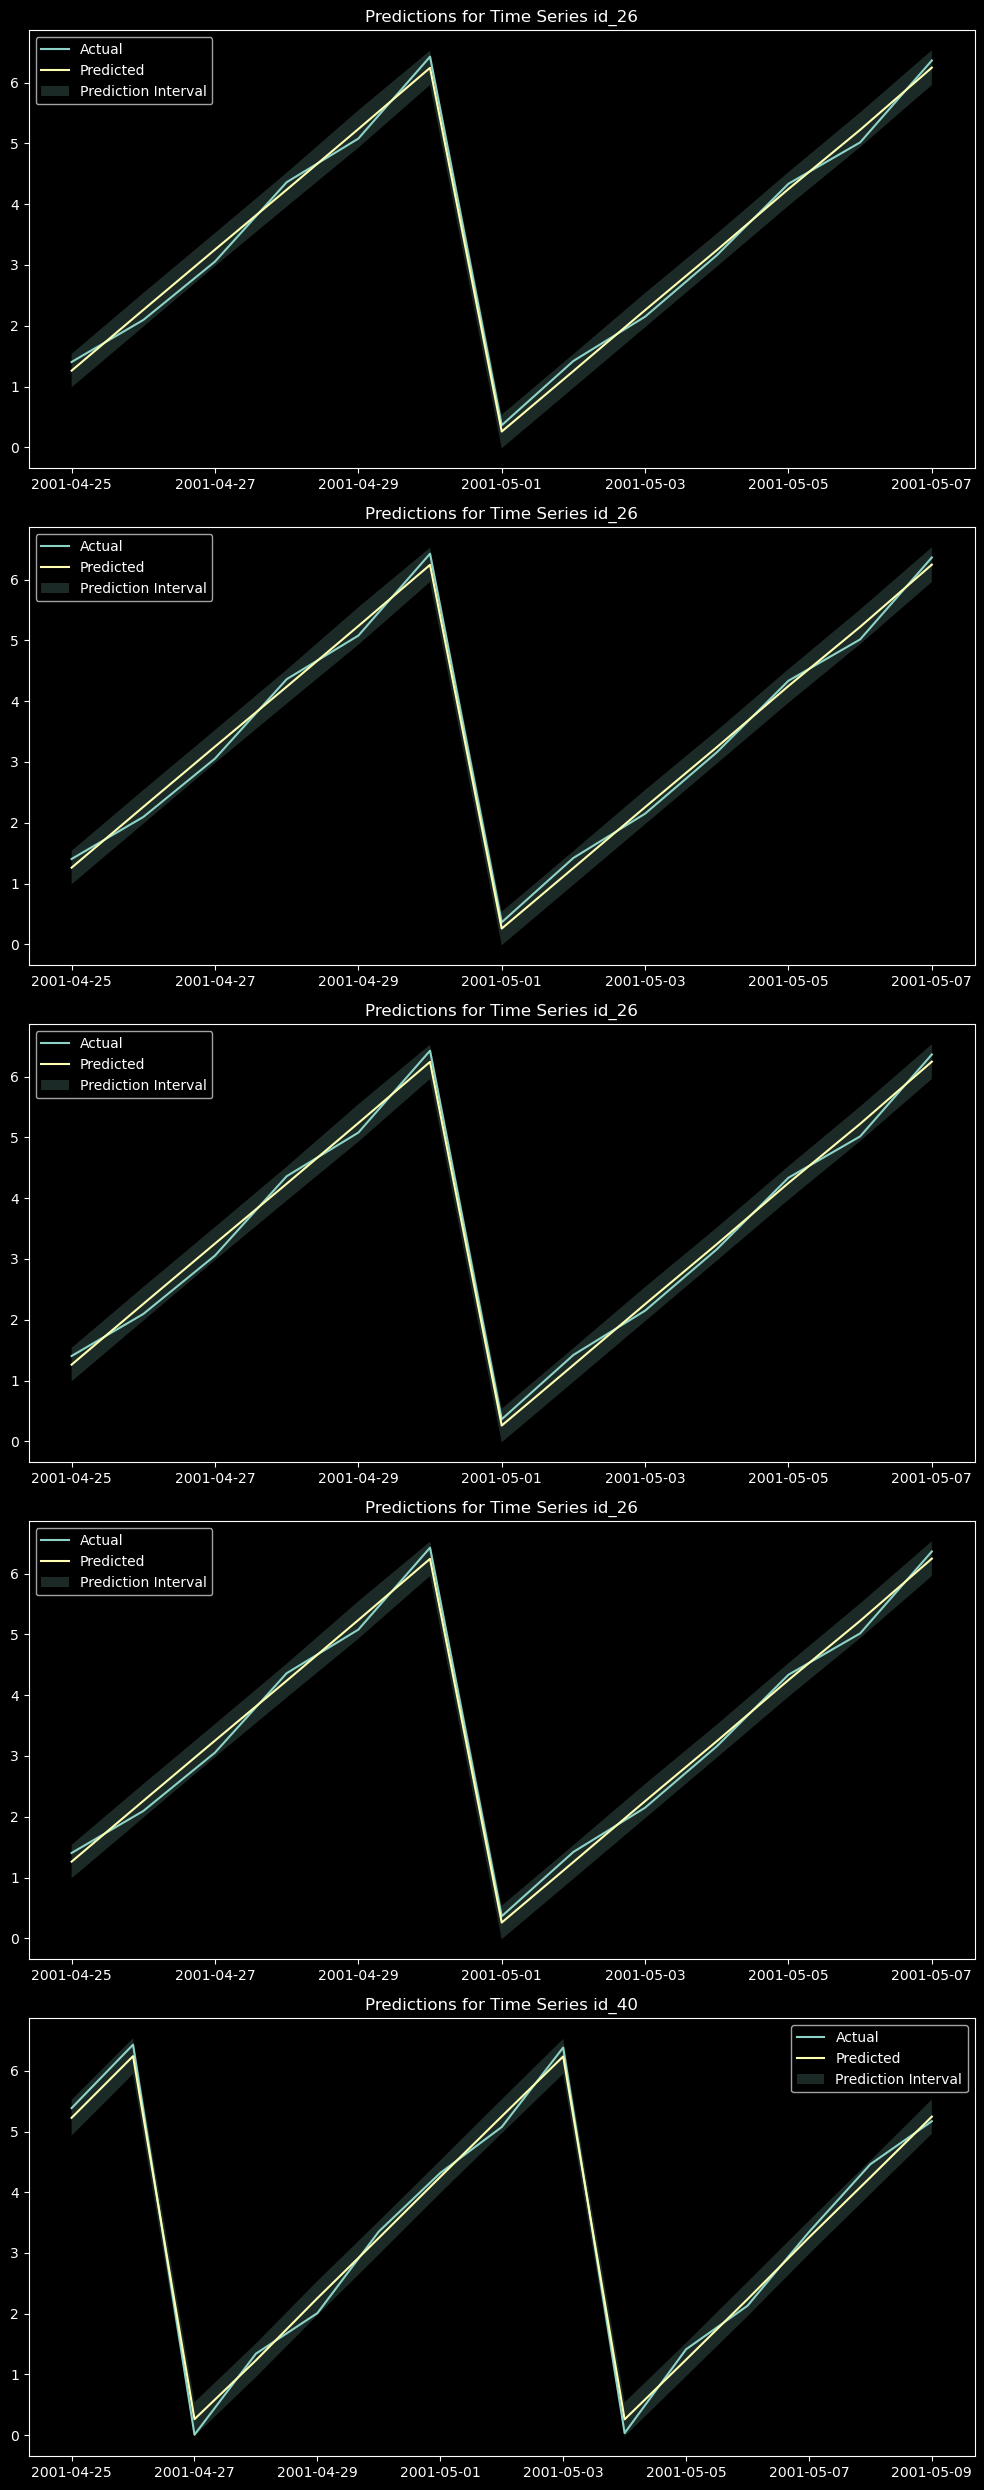

In [15]:
import matplotlib.pyplot as plt

def plot_predictions(val, sample_uids):
  fig, axes = plt.subplots(len(sample_uids), 1, figsize=(10, 5*len(sample_uids)))
  for idx, uid in enumerate(sample_uids):
    val_sample = val[val['unique_id'] == uid]
    axes[idx].plot(val_sample['ds'], val_sample['y'], label='Actual')
    axes[idx].plot(val_sample['ds'], val_sample['pred'], label='Predicted')
    axes[idx].fill_between(val_sample['ds'], val_sample['pred_lower'], val_sample['pred_upper'], alpha=0.2, label='Prediction Interval')
    axes[idx].set_title(f'Predictions for Time Series {uid}')
    axes[idx].legend()
  plt.tight_layout()
  plt.show()

plot_predictions(val, sample_uids)
